In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ! pip install pogema

In [3]:
# ! pip install -r requirements.txt

In [4]:
# ! pip install gym[atari,accept-rom-license]==gym-0.25.0 

In [5]:
# ! pip install atari_py

In [6]:
num_agents = 5

In [7]:
from pogema import pogema_v0, GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=num_agents,  # number of agents
                         size=20, # size of the grid
                         density=0.4,  # obstacle density
                         seed=1,  # set to None for random 
                                  # obstacles, agents and targets 
                                  # positions at each reset
                         max_episode_steps=10 ** 3,  # horizon
                         obs_radius=3,  # defines field of view
                         )

env = pogema_v0(grid_config=grid_config)
env.reset()
env.render()

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                                    .  . 
 .  .     .     .     .  .     .  .  .     3  .     .  .  .  .  .  .     .  . 
 .  .        .  .           .  .  .     . |3|             .  .  .  .     .  . 
 .  .           .  .     .  1     .           .     .  .           .     .  . 
 .  .     .  .           .  .           .  .     .  .  .                 .  . 
 .  .        .     .     .     .  .  .     .  . |1| .  .  .     .        .  . 
 .  .        .           .  4  .     .  .  .  .        .  .  .     .     .  . 
 .  .     .        .  .  .  .  .  .  .  .  .              .        .     .  . 
 .  .     .  .  . |4| .     .     .  .     .  .     .     .  .  .        .  . 
 .  .     .           .  .  .     .        .     .  .  .  .  .     .     .  . 
 .  .        .  .     .  .     .              .     

In [8]:
n_actions = env.action_space.n

n_actions

5

In [9]:
s = env.reset()

def show_state(s):
    plt.figure(figsize=[16, 9])
#     if isinstance(s, torch.Tensor):
        
    for i, k in enumerate(s):
        plt.subplot(2, 3, i + 1)
        
        tr_k = k
        if not isinstance(k, torch.Tensor):
            tr_k = tr_k.transpose(1, 2, 0)
        plt.imshow(tr_k)
        plt.grid()

    plt.show()

In [10]:
action = env.action_space.sample()
action

0

In [11]:
action = [env.action_space.sample() for _ in range(num_agents)]
action

[4, 0, 4, 2, 3]

In [12]:
next_s, reward, is_done, _ =  env.step(action)

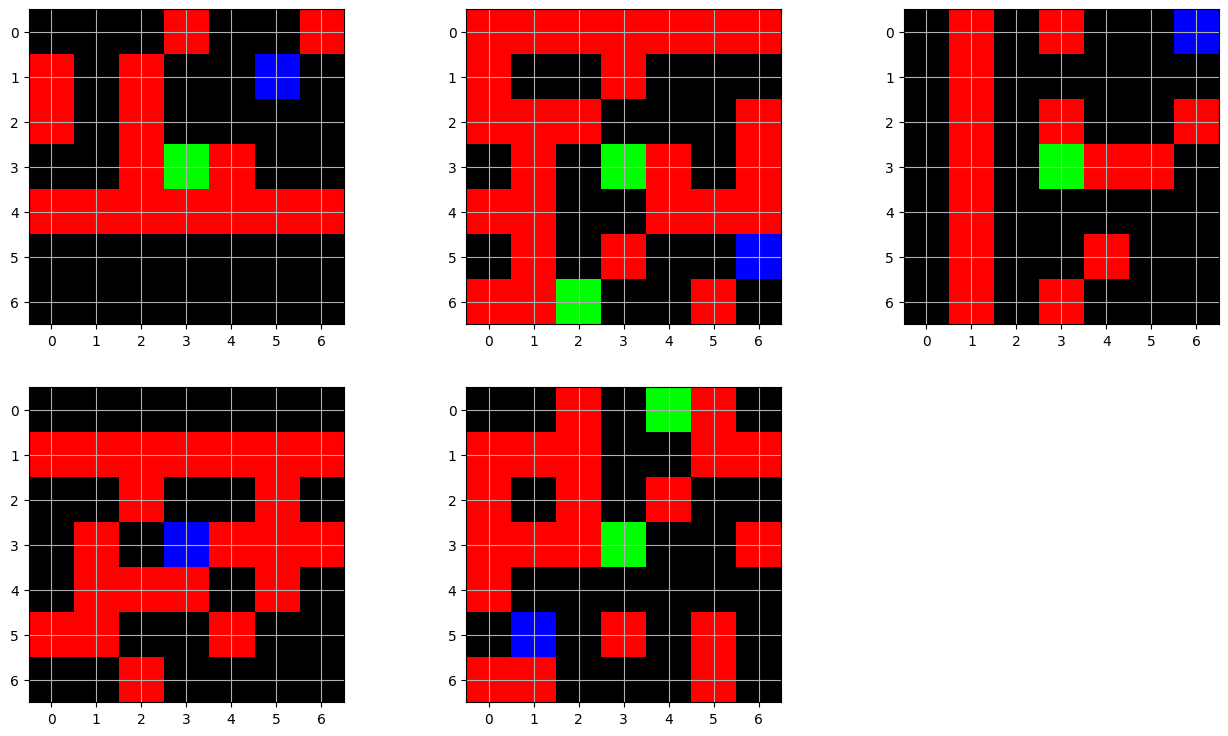

In [13]:
show_state(next_s)

In [14]:
reward, is_done

([0.0, 0.0, 0.0, 1.0, 0.0], [False, False, False, True, False])

In [15]:
is_done = np.array(is_done)
reward = np.array(reward)

max_step = 10 ** 4
step = 0

while is_done.mean() != 1 and step < max_step:
    action = np.array([env.action_space.sample() for _ in range(num_agents)])
    s, reward, is_done, info = env.step(action)
    is_done = np.array(is_done)
    reward = np.array(reward)
    step += 1
    
print(reward, is_done, info)

[0. 0. 0. 0. 0.] [ True  True  True  True  True] [{'is_active': False, 'TimeLimit.truncated': False, 'metrics': {'ISR': 0.6, 'CSR': 0.0, 'ep_length': 537.8}}, {'is_active': False, 'TimeLimit.truncated': False}, {'is_active': True, 'TimeLimit.truncated': True}, {'is_active': False, 'TimeLimit.truncated': False}, {'is_active': True, 'TimeLimit.truncated': True}]


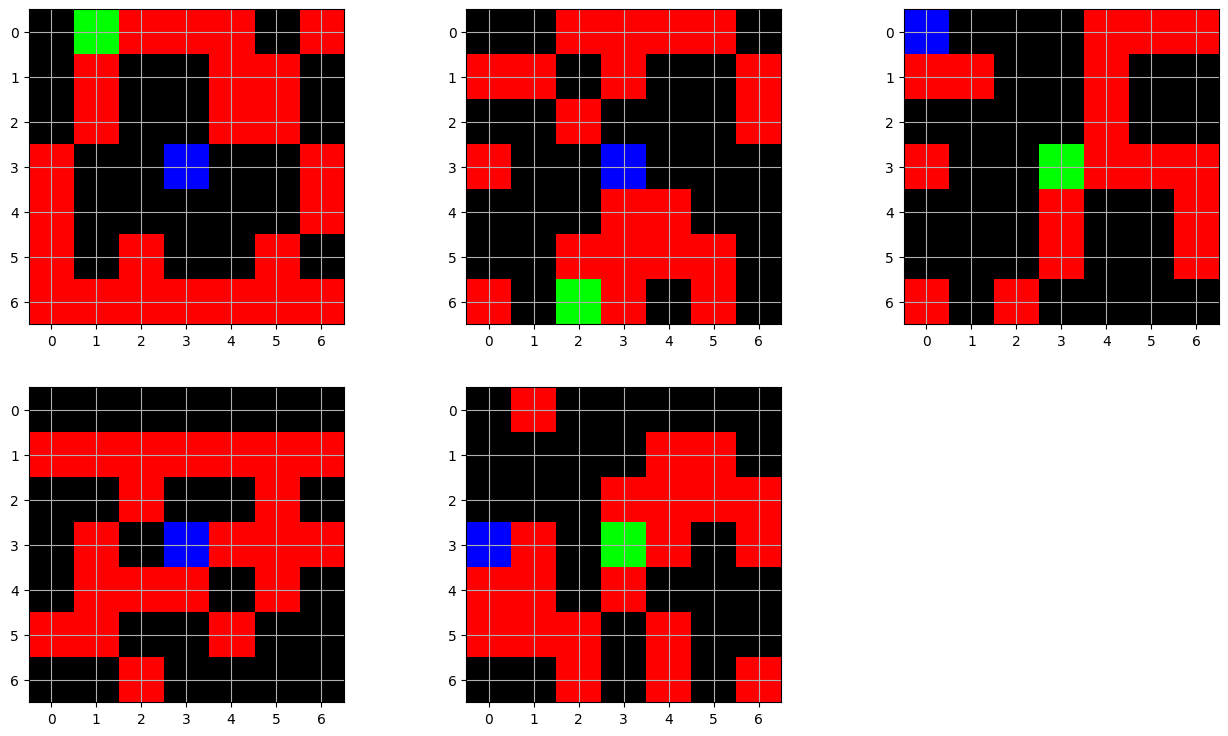

In [16]:
show_state(s)

In [17]:
s[0].shape

(3, 7, 7)

In [33]:
from gym.core import ObservationWrapper
from gym.spaces import Box

class PreprocessObs(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)

    def _to_gray_scale(self, rgb, channel_weights=torch.Tensor([0.5, 0.4, 0.1])):
        return torch.matmul(rgb, channel_weights)


    def observation(self, img):
        img = torch.Tensor(img)
        img.transpose_(3, 1)
        img = self._to_gray_scale(img)
        img = img / 255.0
        return img

tensor(49.8000)
tensor(0.1953)
tensor(49.8000)
tensor(0.1953)


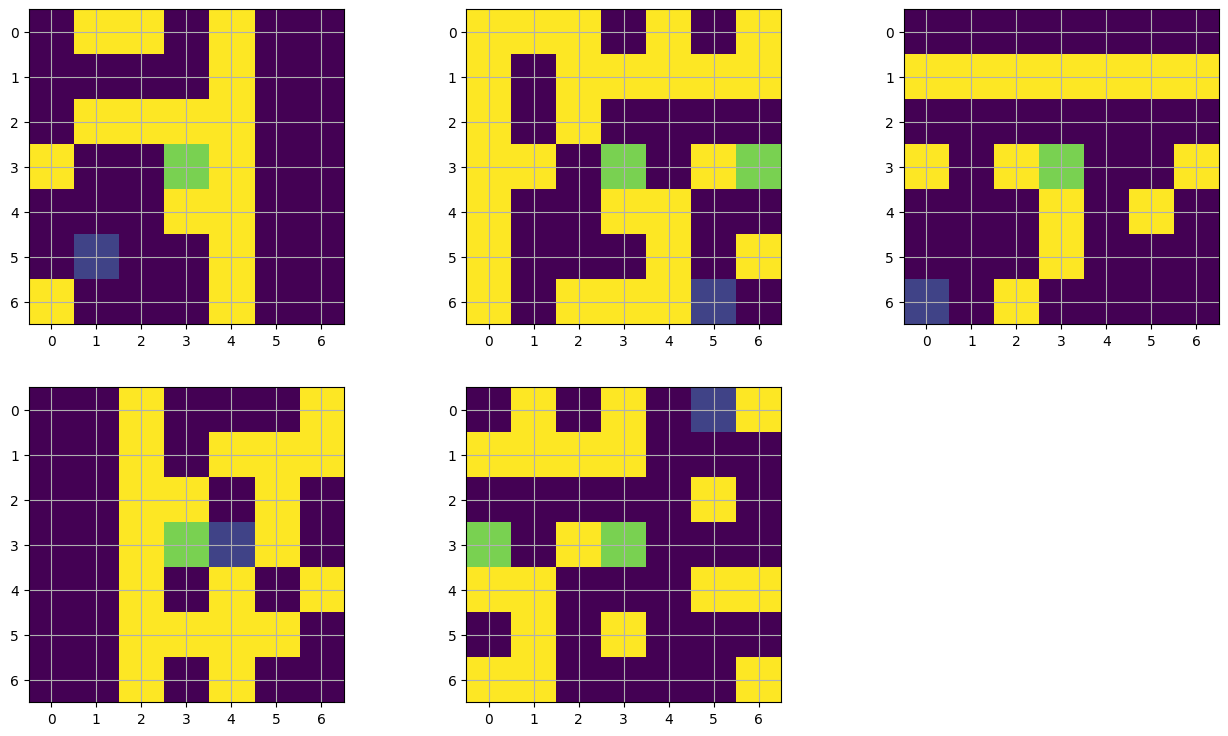

In [34]:
env1 = PreprocessObs(env)
observation_shape = env1.observation_space.shape
n_actions = env1.action_space.n
env1.reset()
obs, _, _, _ = env1.step([env1.action_space.sample() for _ in range(num_agents)])

show_state(obs)

In [87]:
def compute_reward(state, action, next_state, is_done):
    is_done = np.array(is_done)
    action = np.array(action)
    
    reward = (1 - is_done)* (- 0.3 * (action == 0) - 0.5 * (action != 0)) 
    
    reward += 20 * is_done
    return reward

tensor(50.6000)
tensor(0.1984)


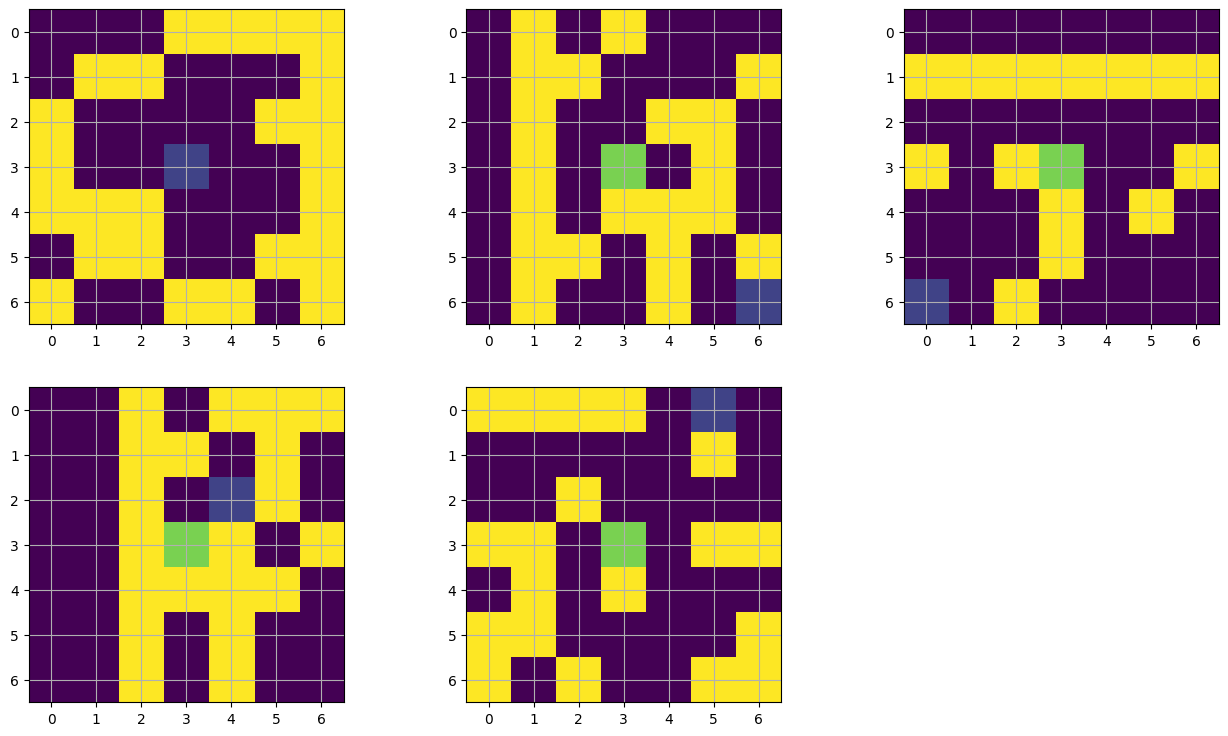

In [88]:
next_s, _, is_done, _ = env1.step([4 for _ in range(num_agents)])
show_state(s)

In [89]:
compute_reward(s, [0 for _ in range(num_agents)], next_s, is_done)

array([20. , -0.3, -0.3, -0.3, -0.3])

##### 